# 1.d&e

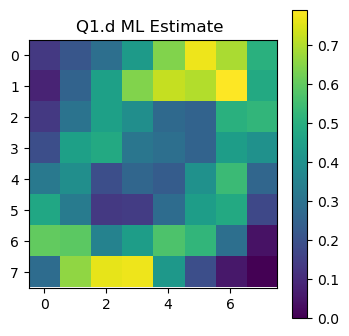

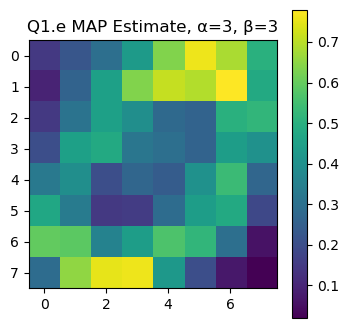

<Figure size 640x480 with 0 Axes>

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Load Data 
data = np.loadtxt('/Users/richardhuang/Documents/GitHub/Projects/Probabilistc Summartive/binarydigits.txt')

def learn_ml_params(data):
    """
    Learn the Maximum Likelihood (ML) parameters for a multivariate Bernoulli distribution.
    This function computes the ML estimate and reshapes it to an 8x8 image format.
    """
    p_mle = np.mean(data, axis=0)
    return p_mle.reshape(8, 8)

def learn_map_params(data, alpha=3, beta=3):
    """
    Learn the Maximum A Posteriori (MAP) parameters for a multivariate Bernoulli distribution
    with Beta prior parameters alpha and beta. This function computes the MAP estimate and 
    reshapes it to an 8x8 image format.
    """
    N = data.shape[0]
    pixel_sums = np.sum(data, axis=0)
    p_map = (pixel_sums + alpha - 1) / (N + alpha + beta - 2)
    return p_map.reshape(8, 8)

# Calculate ML and MAP parameters
p_mle_image = learn_ml_params(data)
p_map_image = learn_map_params(data, alpha=3, beta=3)


plt.figure(figsize=(4, 4))
plt.imshow(p_mle_image, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Q1.d ML Estimate ")
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(p_map_image, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Q1.e MAP Estimate, α=3, β=3")
plt.show()

plt.tight_layout()
plt.show()


# Question 2

In [93]:
# Number of images (N) and number of pixels per image (D)
N, D = data.shape

# Model (a) - Log likelihood
P_x_given_Ma = N * D * np.log(0.5)

# Model (b) - Log likelihood
P_x_given_Mb = np.sum(np.log(np.power(p_d_b, np.sum(data, axis=0)) * np.power(1 - p_d_b, N - np.sum(data, axis=0))))

# Model (c) - Log likelihood
P_x_given_Mc = np.sum(np.sum(np.log(np.power(p_d_b, data) * np.power(1 - p_d_b, 1 - data)), axis=0))

# Priors
P_Ma = P_Mb = P_Mc = 1/3

# Evidence (marginal likelihood)
P_x = P_x_given_Ma * P_Ma + P_x_given_Mb * P_Mb + P_x_given_Mc * P_Mc


if P_x == 0:
    print("Warning: The evidence (P_x) is zero!")

# Posterior probabilities using Bayes' theorem
P_Ma_given_x = (P_x_given_Ma * P_Ma) / P_x if P_x != 0 else 0
P_Mb_given_x = (P_x_given_Mb * P_Mb) / P_x if P_x != 0 else 0
P_Mc_given_x = (P_x_given_Mc * P_Mc) / P_x if P_x != 0 else 0


print(f"Posterior probability for Model (a): {P_Ma_given_x}")
print(f"Posterior probability for Model (b): {P_Mb_given_x}")
print(f"Posterior probability for Model (c): {P_Mc_given_x}")

Posterior probability for Model (a): 0.3743499744946563
Posterior probability for Model (b): 0.3128250127526718
Posterior probability for Model (c): 0.3128250127526718


# Question 3

## (e) Log-likelihood function vs iterations 

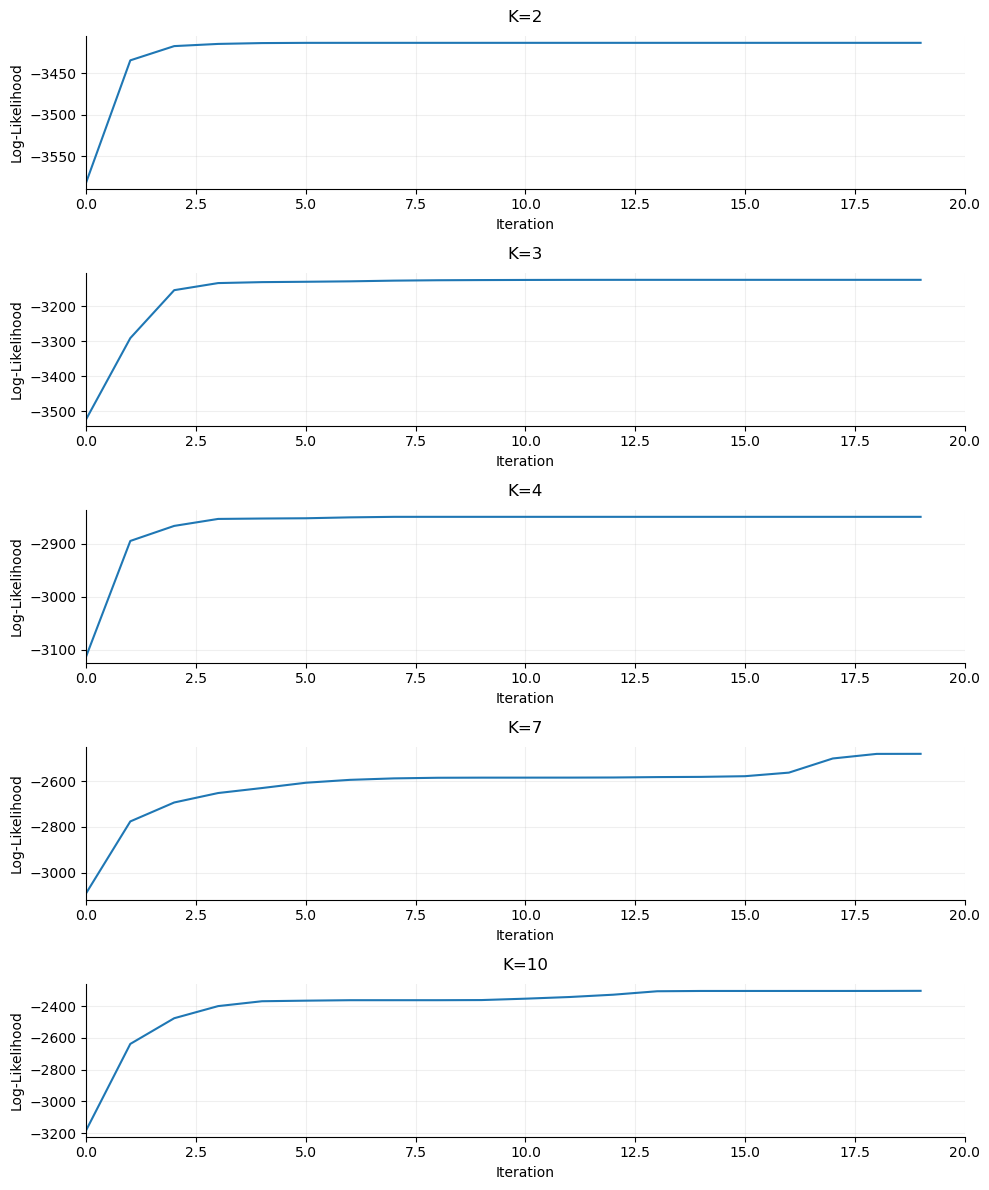

In [46]:
# Initialize the parameters for EM algorithm
def initialize_parameters(K, D):
    # Randomly initialize mixing proportions and ensure they sum to 1
    pi = np.random.dirichlet(alpha=np.ones(K), size=1)[0]
    
    P = 0.2 + 0.6 * np.random.rand(K, D)
    return pi, P

# Calculate the log-likelihood of the data
def compute_log_likelihood(X, pi, P):
    N, D = X.shape
    K = pi.shape[0]
    log_likelihood = 0
    for n in range(N):
        log_prob_sum = np.log(np.sum([
            pi[k] * np.prod(P[k]**X[n] * (1 - P[k])**(1 - X[n])) for k in range(K)
        ]))
        log_likelihood += log_prob_sum
    return log_likelihood

# E-step: calculate responsibilities
def e_step(X, pi, P):
    N, D = X.shape
    K = pi.shape[0]
    responsibilities = np.zeros((N, K))
    
    for n in range(N):
        log_resps = np.array([
            np.log(pi[k] + 1e-10) + np.sum(X[n] * np.log(P[k] + 1e-10) + (1 - X[n]) * np.log(1 - P[k] + 1e-10)) 
            for k in range(K)
        ])
        max_log_resp = np.max(log_resps)
        log_resps -= max_log_resp 
        responsibilities[n, :] = np.exp(log_resps)
        responsibilities[n, :] /= np.sum(responsibilities[n, :])  
        
    return responsibilities

# M-step: update parameters based on responsibilities
def m_step(X, responsibilities):
    N, D = X.shape
    K = responsibilities.shape[1]
    pi_new = np.sum(responsibilities, axis=0) / N
    P_new = np.dot(responsibilities.T, X) / np.sum(responsibilities, axis=0)[:, None]
    return pi_new, P_new

# EM algorithm
def plot_log_likelihoods_subplots(data, K_values):
    """Plot log-likelihoods in the specified format"""
    fig, axes = plt.subplots(len(K_values), 1, figsize=(10, 12))
    

    
    for idx, K in enumerate(K_values):
        # Run EM
        pi, P, log_likelihoods = em_algorithm(data, K, max_iter=20)
        
        # Plot
        ax = axes[idx]
        ax.plot(np.arange(len(log_likelihoods)), log_likelihoods, '-', linewidth=1.5, color='#1f77b4')
        
        ax.set_title(f'K={K}', pad=10)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Log-Likelihood')
        
        ax.set_xlim(0, 20) 
        
        ax.grid(True, linestyle='-', alpha=0.2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.tick_params(direction='out')
        
    plt.tight_layout()
    plt.show()

# Modified EM algorithm to ensure proper convergence behavior
def em_algorithm(X, K, max_iter=20):
    """EM algorithm with fixed number of iterations"""
    pi, P = initialize_parameters(K, X.shape[1])
    log_likelihoods = []
    
    for _ in range(max_iter):
        # E-step
        resp = e_step(X, pi, P)
        
        # M-step
        pi, P = m_step(X, resp)
        
        # Compute and store log likelihood
        log_likelihood = compute_log_likelihood(X, pi, P)
        log_likelihoods.append(log_likelihood)
    
    return pi, P, log_likelihoods

# Run with the specified K values
data = np.loadtxt('binarydigits.txt')

plot_log_likelihoods_subplots(data, [2, 3, 4, 7, 10])



## Parameters found for different K values

/var/folders/xz/61c109t15cx43gsh590qx9180000gn/T/ipykernel_72819/1375267480.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


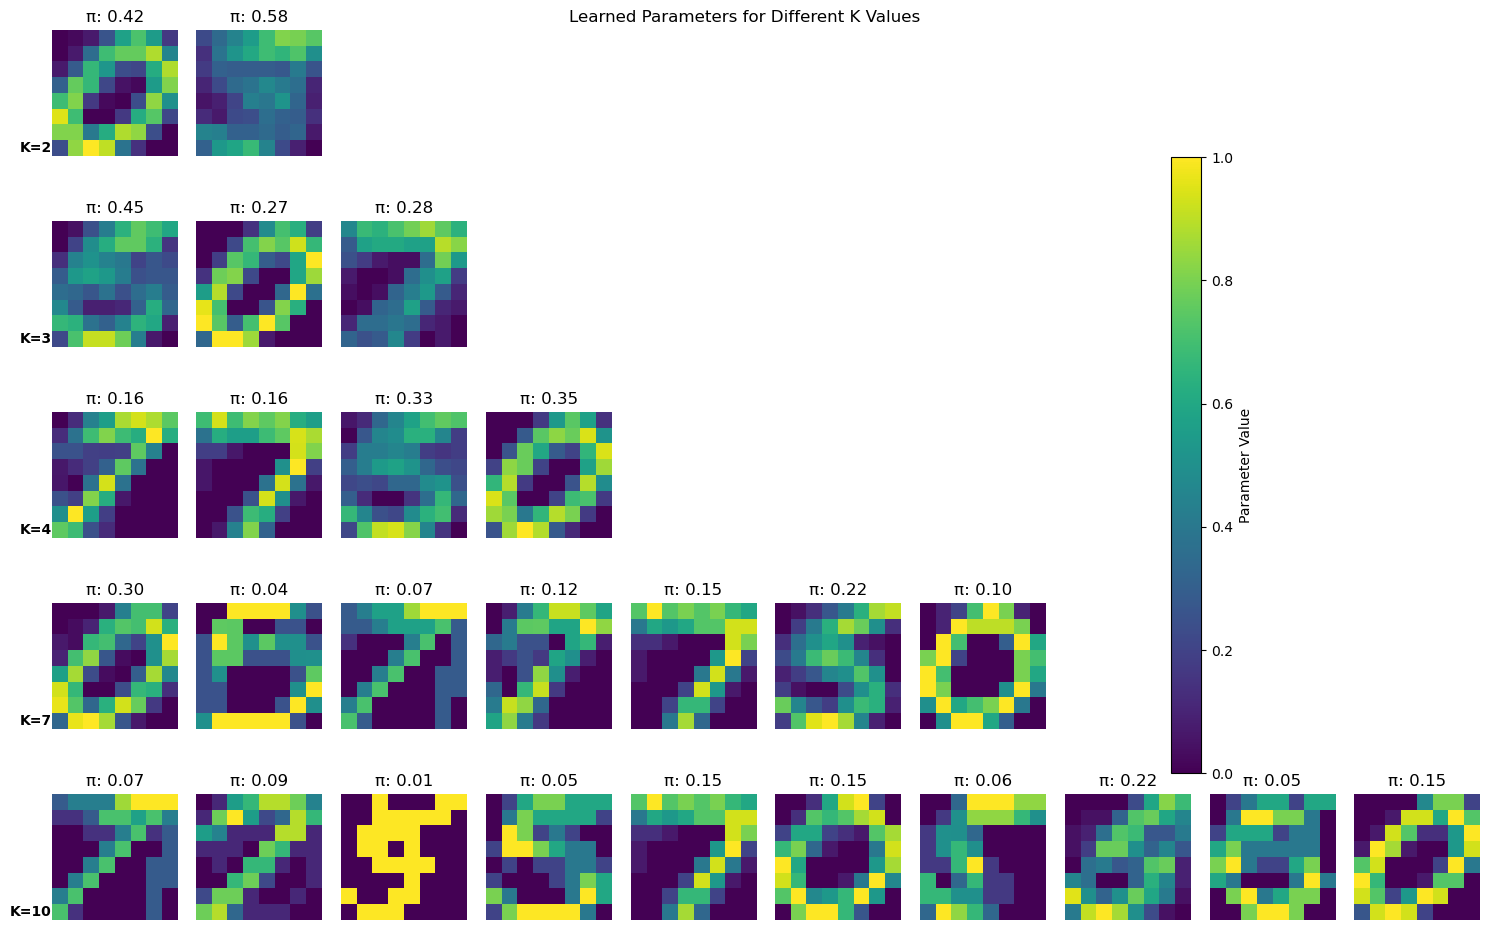

In [40]:
plt.figure(figsize=(15, 10))

max_K = 10
subplot_idx = 1

for K in [2, 3, 4, 7, 10]:
    # Run EM algorithm
    pi, P, log_likelihoods = em_algorithm(data, K, 20)
    
    # Plot each component for current K
    for k in range(K):
        subplot_pos = (subplot_idx - 1) * max_K + k + 1
        plt.subplot(5, max_K, subplot_pos)
        
        # Display the image
        component_params = P[k].reshape(8, 8)
        im = plt.imshow(component_params, 
                       cmap='viridis',
                       vmin=0, 
                       vmax=1,
                       interpolation='nearest')
        plt.axis('off')
        
        # Add pi value above each component
        plt.title(f'π: {pi[k]:.2f}')
        
        # Add K value to bottom-left corner of first component in each row
        if k == 0:
            plt.text(-0.5, 7, f'K={K}', 
                    color='black', 
                    fontweight='bold',
                    fontsize=10,
                    ha='right',
                    va='center')
    
    subplot_idx += 1

plt.colorbar(im, ax=plt.gcf().axes, shrink=0.8, label='Parameter Value')

plt.suptitle('Learned Parameters for Different K Values', y=0.95)
plt.tight_layout()
plt.show()

## t-SNE Visualization of Responsibilities for Different K Values

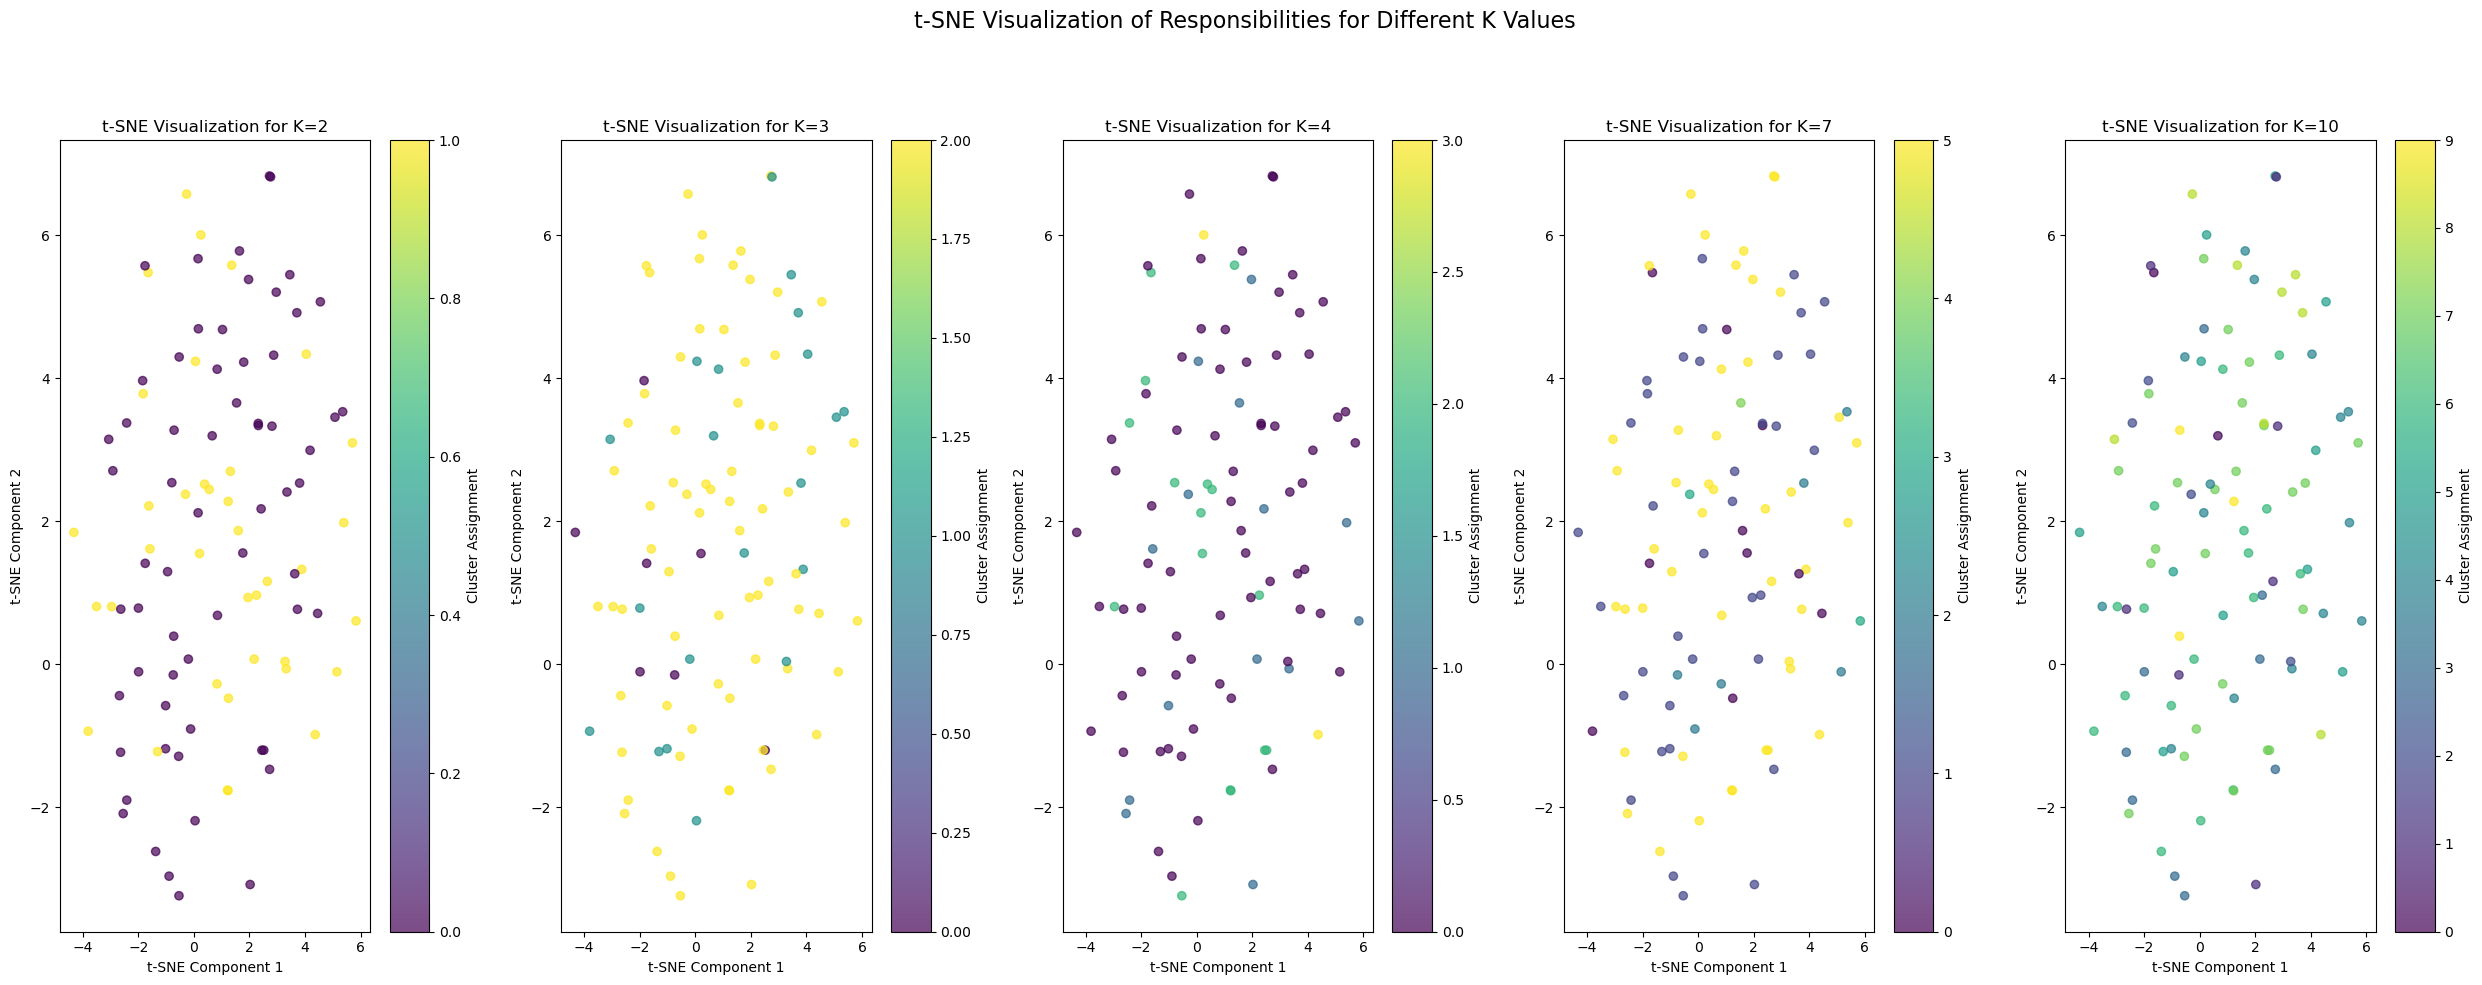

In [95]:
from sklearn.manifold import TSNE

def visualize_responsibilities_tsne(X, pi_list, P_list, k_values):
    """
    Visualize the responsibilities for different K values using t-SNE.
    
    Parameters:
    X : numpy.ndarray
        The input data, shape (N, D) where N is the number of data points and D is the number of features.
    pi_list : list of numpy.ndarray
        List of mixing proportions for each K, each shape (K,).
    P_list : list of numpy.ndarray
        List of cluster parameters for each K, each shape (K, D).
    k_values : list of int
        List of K values corresponding to pi_list and P_list.
    """
    num_k = len(k_values)
    plt.figure(figsize=(25, 10))
    
    for idx, K in enumerate(k_values):
        # Compute responsibilities for the current K
        responsibilities = e_step(X, pi_list[idx], P_list[idx])
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        data_tsne = tsne.fit_transform(X)
        
        # Get cluster assignments based on maximum responsibility
        cluster_assignments = np.argmax(responsibilities, axis=1)
        
        plt.subplot(1, num_k, idx + 1)
        plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Visualization for K={K}')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.colorbar(label='Cluster Assignment')
    
    plt.suptitle('t-SNE Visualization of Responsibilities for Different K Values', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
k_values = [2, 3, 4, 7, 10]
pi_list = [np.random.dirichlet(np.ones(K), size=1)[0] for K in k_values]
P_list = [np.random.rand(K, D) for K in k_values]

visualize_responsibilities_tsne(X, pi_list, P_list, k_values)

## (f)Compression Rate for Different K Values

In [74]:
import numpy as np

def em_algorithm_compression_rate(X, K, max_iter=20):
    """
    Parameters:
    - X: Data matrix (N x D), where N is the number of data points and D is the dimensionality.
    - K: Number of clusters/components.
    - max_iter: Maximum number of iterations for the EM algorithm.
    
    Returns:
    - final_log_likelihood_bits: Final log-likelihood value in bits (base 2).
    - compression_rate: Compression rate compared to the naive encoding.
    """
    # Initialize parameters
    N, D = X.shape
    pi, P = initialize_parameters(K, D)
    log_likelihoods = []
    
    for _ in range(max_iter):
        # E-step
        resp = e_step(X, pi, P)
        
        # M-step
        pi, P = m_step(X, resp)
        
        # Compute and store log-likelihood in natural log
        log_likelihood = compute_log_likelihood(X, pi, P)
        log_likelihoods.append(log_likelihood)
    
    # Convert the final log-likelihood to bits
    final_log_likelihood_bits = log_likelihoods[-1] / np.log(2)
    
    # Calculate naive encoding length in bits
    naive_encoding_length = N * D
    
    # Calculate compression rate
    compression_rate = 1 - (-final_log_likelihood_bits / naive_encoding_length)
    
    return final_log_likelihood_bits, compression_rate

def compute_compression_rates_for_different_K(X, K_values, max_iter=20):
    """
    Parameters:
    - X: Data matrix (N x D).
    - K_values: List of integers, where each integer is a value of K (number of clusters) to evaluate.
    - max_iter: Maximum number of iterations for the EM algorithm.
    
    Returns:
    - results: Dictionary where keys are K values and values are tuples (final_log_likelihood_bits, compression_rate).
    """
    results = {}
    for K in K_values:
        final_log_likelihood_bits, compression_rate = em_algorithm_compression_rate(X, K, max_iter)
        results[K] = (final_log_likelihood_bits, compression_rate)
        print(f"K={K}: Final log-likelihood in bits = {final_log_likelihood_bits}, Compression rate = {compression_rate}")
    return results
  
K_values = [2, 3, 4, 7, 10]  
results = compute_compression_rates_for_different_K(data, K_values, max_iter=20)

print(results)


K=2: Final log-likelihood in bits = -4766.073793569607, Compression rate = 0.2553009697547489
K=3: Final log-likelihood in bits = -4501.190544586443, Compression rate = 0.2966889774083683
K=4: Final log-likelihood in bits = -4111.285714552049, Compression rate = 0.3576116071012423
K=7: Final log-likelihood in bits = -3486.149343249853, Compression rate = 0.4552891651172105
K=10: Final log-likelihood in bits = -3441.562569271823, Compression rate = 0.46225584855127766
{2: (-4766.073793569607, 0.2553009697547489), 3: (-4501.190544586443, 0.2966889774083683), 4: (-4111.285714552049, 0.3576116071012423), 7: (-3486.149343249853, 0.4552891651172105), 10: (-3441.562569271823, 0.46225584855127766)}


## (g)Total Cost and Compression Rate for Different K Values

In [82]:
import numpy as np
import pandas as pd

def em_algorithm_total_cost_and_compression_rate_single_run(X, K_values, max_iter=20, M=64):
    """
    Computes the total cost and total compression rate for different values of K with a single run per K.

    Parameters:
    - X: Data matrix (N x D), where N is the number of data points and D is the dimensionality.
    - K_values: List of integers, the different values of K (number of clusters) to evaluate.
    - max_iter: Maximum number of iterations for the EM algorithm.
    - M: Cost in bits to store each parameter (default is 64 bits for a float64).

    Returns:
    - results_df: DataFrame with total compression rates for each K value.
    """
    N, D = X.shape
    naive_encoding_length = N * D 
    results = {"K": [], "Total Cost": [], "Total Compression Rate": []}

    for K in K_values:
        pi, P = initialize_parameters(K, D)
        log_likelihoods = []

        # EM Algorithm
        for _ in range(max_iter):
            # E-step
            resp = e_step(X, pi, P)
            # M-step
            pi, P = m_step(X, resp)
            # Compute log-likelihood
            log_likelihood = compute_log_likelihood(X, pi, P)
            log_likelihoods.append(log_likelihood)

        # Final log-likelihood in bits
        final_log_likelihood_nats = log_likelihoods[-1]
        final_log_likelihood_bits = final_log_likelihood_nats / np.log(2)  # Convert to bits

        # Cost of encoding the model parameters
        num_params = (K - 1) + K * D
        model_cost_bits = num_params * M

        # Total cost in bits
        total_cost = -final_log_likelihood_bits + model_cost_bits

        # Total compression rate
        total_compression_rate = total_cost / naive_encoding_length

        results["K"].append(K)
        results["Total Cost"].append(total_cost)
        results["Total Compression Rate"].append(total_compression_rate)

    results_df = pd.DataFrame(results)
    
    return results_df

K_values = [2, 3, 4, 7, 10]

# Run the computation
results_df = em_algorithm_total_cost_and_compression_rate_single_run(X, K_values, max_iter=20, M=64)

print(results_df)


    K    Total Cost  Total Compression Rate
0   2  11523.677864                1.800575
1   3  15700.663921                2.453229
2   4  19808.043613                3.095007
3   7  32117.223560                5.018316
4  10  44521.132382                6.956427


# Question 4

In [44]:
def run_ssm_kalman(X, y_init, Q_init, A, Q, C, R, mode='smooth'):
    """
    Calculates kalman-smoother estimates of SSM state posterior.
    :param X:       data, [d, t_max] numpy array
    :param y_init:  initial latent state, [k,] numpy array
    :param Q_init:  initial variance, [k, k] numpy array
    :param A:       latent dynamics matrix, [k, k] numpy array
    :param Q:       innovariations covariance matrix, [k, k] numpy array
    :param C:       output loading matrix, [d, k] numpy array
    :param R:       output noise matrix, [d, d] numpy array
    :param mode:    'forw' or 'filt' for forward filtering, 'smooth' for also backward filtering
    :return:
    y_hat:      posterior mean estimates, [k, t_max] numpy array
    V_hat:      posterior variances on y_t, [t_max, k, k] numpy array
    V_joint:    posterior covariances between y_{t+1}, y_t, [t_max, k, k] numpy array
    likelihood: conditional log-likelihoods log(p(x_t|x_{1:t-1})), [t_max,] numpy array
    """
    d, k = C.shape
    t_max = X.shape[1]

    # dimension checks
    assert np.all(X.shape == (d, t_max)), "Shape of X must be (%d, %d), %s provided" % (d, t_max, X.shape)
    assert np.all(y_init.shape == (k,)), "Shape of y_init must be (%d,), %s provided" % (k, y_init.shape)
    assert np.all(Q_init.shape == (k, k)), "Shape of Q_init must be (%d, %d), %s provided" % (k, k, Q_init.shape)
    assert np.all(A.shape == (k, k)), "Shape of A must be (%d, %d), %s provided" % (k, k, A.shape)
    assert np.all(Q.shape == (k, k)), "Shape of Q must be (%d, %d), %s provided" % (k, k, Q.shape)
    assert np.all(C.shape == (d, k)), "Shape of C must be (%d, %d), %s provided" % (d, k, C.shape)
    assert np.all(R.shape == (d, d)), "Shape of R must be (%d, %d), %s provided" % (d, k, R.shape)

    y_filt = np.zeros((k, t_max))  # filtering estimate: \hat(y)_t^t
    V_filt = np.zeros((t_max, k, k))  # filtering variance: \hat(V)_t^t
    y_hat = np.zeros((k, t_max))  # smoothing estimate: \hat(y)_t^T
    V_hat = np.zeros((t_max, k, k))  # smoothing variance: \hat(V)_t^T
    K = np.zeros((t_max, k, X.shape[0]))  # Kalman gain
    J = np.zeros((t_max, k, k))  # smoothing gain
    likelihood = np.zeros(t_max)  # conditional log-likelihood: p(x_t|x_{1:t-1})

    I_k = np.eye(k)

    # forward pass

    V_pred = Q_init
    y_pred = y_init

    for t in range(t_max):
        x_pred_err = X[:, t] - C.dot(y_pred)
        V_x_pred = C.dot(V_pred.dot(C.T)) + R
        V_x_pred_inv = np.linalg.inv(V_x_pred)
        likelihood[t] = -0.5 * (np.linalg.slogdet(2 * np.pi * (V_x_pred))[1] +
                                x_pred_err.T.dot(V_x_pred_inv).dot(x_pred_err))

        K[t] = V_pred.dot(C.T).dot(V_x_pred_inv)

        y_filt[:, t] = y_pred + K[t].dot(x_pred_err)
        V_filt[t] = V_pred - K[t].dot(C).dot(V_pred)

        # symmetrise the variance to avoid numerical drift
        V_filt[t] = (V_filt[t] + V_filt[t].T) / 2.0

        y_pred = A.dot(y_filt[:, t])
        V_pred = A.dot(V_filt[t]).dot(A.T) + Q

    # backward pass

    if mode == 'filt' or mode == 'forw':
        # skip if filtering/forward pass only
        y_hat = y_filt
        V_hat = V_filt
        V_joint = None
    else:
        V_joint = np.zeros_like(V_filt)
        y_hat[:, -1] = y_filt[:, -1]
        V_hat[-1] = V_filt[-1]

        for t in range(t_max - 2, -1, -1):
            J[t] = V_filt[t].dot(A.T).dot(np.linalg.inv(A.dot(V_filt[t]).dot(A.T) + Q))
            y_hat[:, t] = y_filt[:, t] + J[t].dot((y_hat[:, t + 1] - A.dot(y_filt[:, t])))
            V_hat[t] = V_filt[t] + J[t].dot(V_hat[t + 1] - A.dot(V_filt[t]).dot(A.T) - Q).dot(J[t].T)

        V_joint[-2] = (I_k - K[-1].dot(C)).dot(A).dot(V_filt[-2])

        for t in range(t_max - 3, -1, -1):
            V_joint[t] = V_filt[t + 1].dot(J[t].T) + J[t + 1].dot(V_joint[t + 1] - A.dot(V_filt[t + 1])).dot(J[t].T)

    return y_hat, V_hat, V_joint, likelihood

In [101]:
# Define parameters
X = np.loadtxt('/Users/richardhuang/Documents/GitHub/Projects/Probabilistc Summartive/ssm_spins.txt').T

A = 0.99 * np.array([
    [np.cos(2 * np.pi / 180), -np.sin(2 * np.pi / 180), 0, 0],
    [np.sin(2 * np.pi / 180), np.cos(2 * np.pi / 180), 0, 0],
    [0, 0, np.cos(2 * np.pi / 90), -np.sin(2 * np.pi / 90)],
    [0, 0, np.sin(2 * np.pi / 90), np.cos(2 * np.pi / 90)]
])

C = np.array([
    [1, 1, 0, 1],
    [0, 1, 1, 1],
    [1, 0, 1, 1],
    [0, 0, 1, 1],
    [0.5, 0.5, 0.5, 0.5]
])

Q = np.eye(4) - A @ A.T
R = np.eye(5)
y_init = np.zeros(4)
Q_init = np.eye(4)

def logdet(A):
    return 2 * np.sum(np.log(np.diag(np.linalg.cholesky(A))))


Y_filt, V_filt, _, L_filt = run_ssm_kalman(X, y_init, Q_init, A, Q, C, R , 'filt' )
y_smooth, V_smooth, V_joint, L_smooth = run_ssm_kalman(X, y_init, Q_init, A, Q, C, R , 'smooth' )



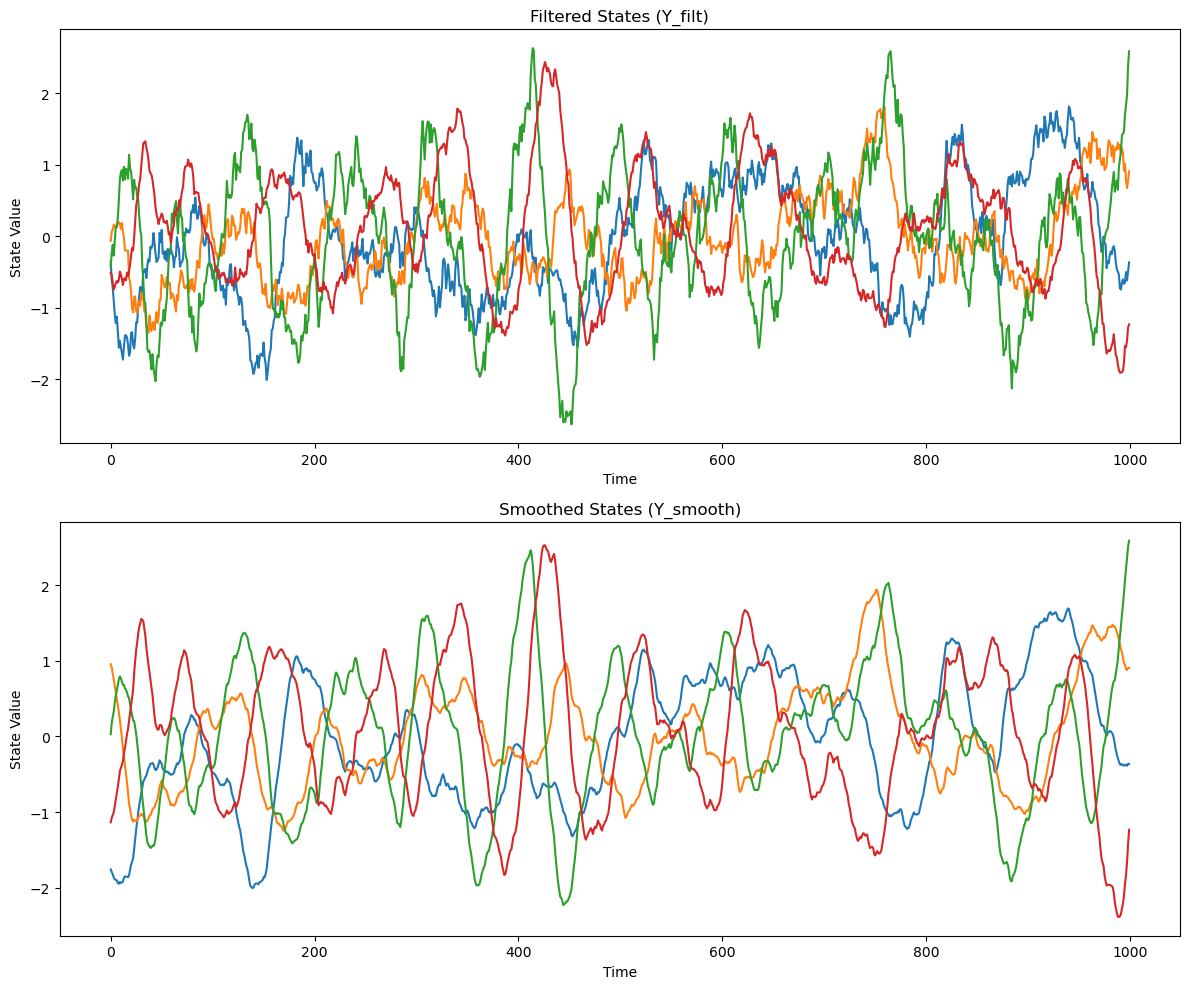

In [102]:
# Create a single figure with a 2x1 layout for Y_filt and Y_smooth
plt.figure(figsize=(12, 10))

# Plot the filtered states (Y_filt) on the first subplot
plt.subplot(2, 1, 1)
plt.plot(y_filt.T)
plt.title("Filtered States (Y_filt)")
plt.xlabel("Time")
plt.ylabel("State Value")

# Plot the smoothed states (Y_smooth) on the second subplot
plt.subplot(2, 1, 2)
plt.plot(y_smooth.T)
plt.title("Smoothed States (Y_smooth)")
plt.xlabel("Time")
plt.ylabel("State Value")

# Display the combined plot
plt.tight_layout()
plt.show()

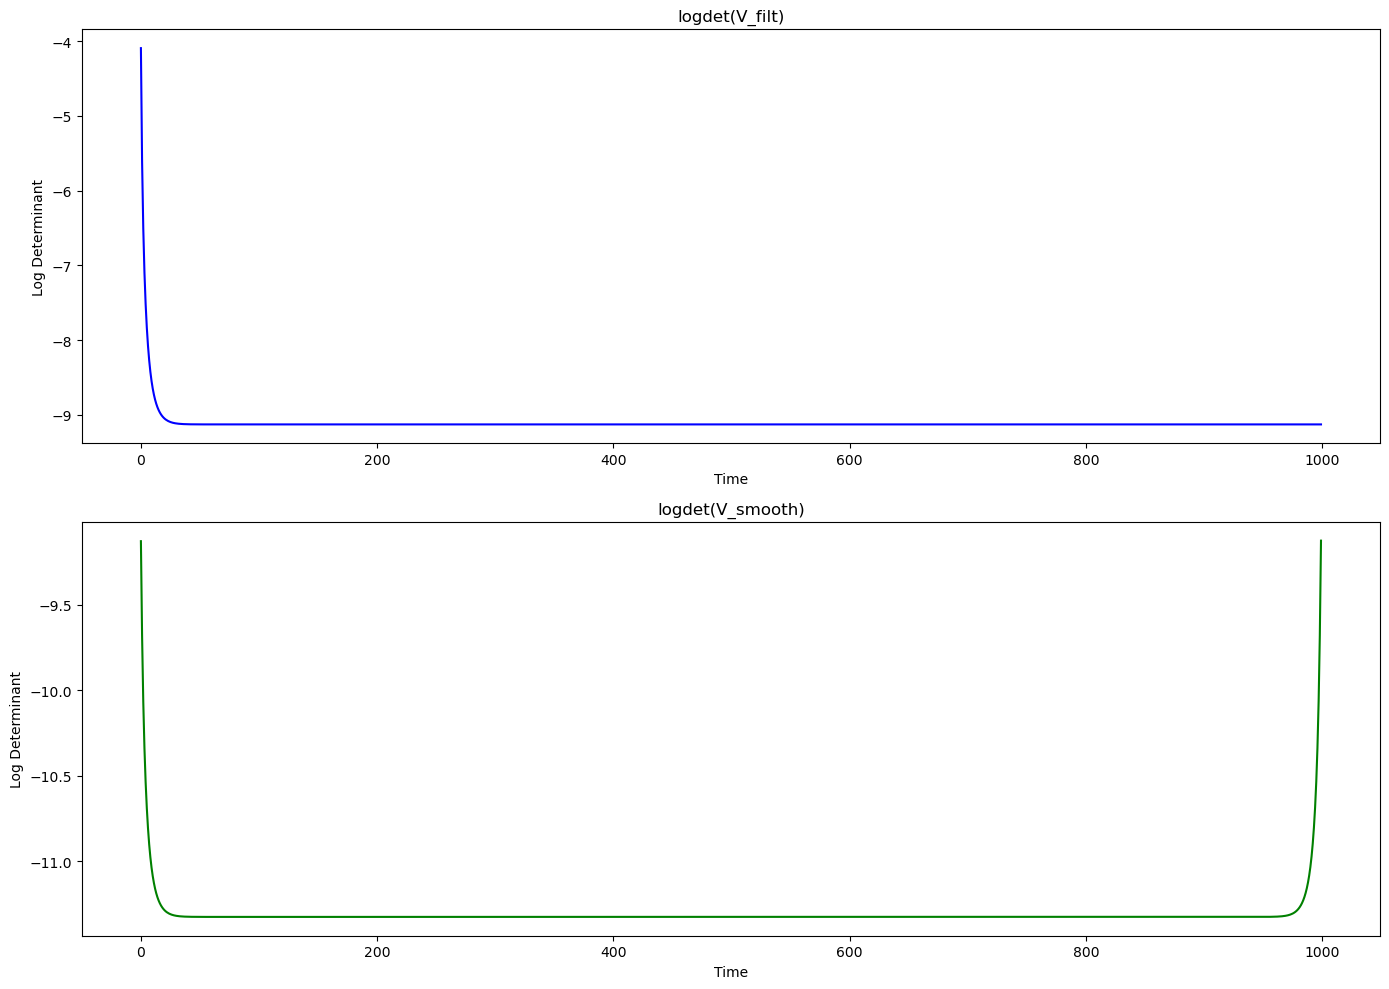

In [103]:
import matplotlib.pyplot as plt

# Calculate log determinants for V_filt and V_smooth
logdet_V_filt = [logdet(V_filt[t]) for t in range(len(V_filt))]
logdet_V_smooth = [logdet(V_smooth[t]) for t in range(len(V_smooth))]

# Create a single figure with a 1x2 layout
plt.figure(figsize=(14, 10))

# Plot logdet(V_filt) on the first subplot
plt.subplot(2,1, 1)
plt.plot(logdet_V_filt, color='blue')
plt.title("logdet(V_filt)")
plt.xlabel("Time")
plt.ylabel("Log Determinant")

# Plot logdet(V_smooth) on the second subplot
plt.subplot(2,1, 2)
plt.plot(logdet_V_smooth, color='green')
plt.title("logdet(V_smooth)")
plt.xlabel("Time")
plt.ylabel("Log Determinant")

# Display the combined plot
plt.tight_layout()
plt.show()


## (b) EM Algorithm for Learning Parameters

In [115]:
def cellsum(C):
    """
    Sums a list of matrices element-wise.
    :param C: List of matrices (numpy arrays) to sum
    :return: Element-wise sum of all matrices in C
    """
    return np.sum(np.stack(C, axis=2), axis=2)

def em_algorithm(X, A_init, Q_init, C_init, R_init, y_init, Q_0, num_iterations=100):
    """
    EM algorithm for learning the parameters A, Q, C, and R.
    :param X: Observation data, shape [d, T]
    :param A_init: Initial A matrix
    :param Q_init: Initial Q matrix
    :param C_init: Initial C matrix
    :param R_init: Initial R matrix
    :param y_init: Initial state vector
    :param Q_0: Initial state covariance
    :param num_iterations: Number of EM iterations
    :return: Updated A, Q, C, R matrices and log-likelihoods
    """
    A, Q, C, R = A_init, Q_init, C_init, R_init
    T = X.shape[1]
    log_likelihoods = []

    for i in range(num_iterations):
        y_hat, V_hat, V_joint, log_likelihood = run_ssm_kalman(X, y_init, Q_0, A, Q, C, R, mode='smooth')
        log_likelihoods.append(np.sum(log_likelihood))

        # M-step: Update parameters A, Q, C, and R

        # Update C
        C_new = (cellsum([np.outer(X[:, t], y_hat[:, t]) for t in range(T)]) @
                 np.linalg.inv(cellsum([V_hat[t] + np.outer(y_hat[:, t], y_hat[:, t]) for t in range(T)])))

        # Update R
        R_new = (1 / T) * (cellsum([np.outer(X[:, t], X[:, t]) for t in range(T)]) -
                           cellsum([np.outer(X[:, t], y_hat[:, t]) for t in range(T)]) @ C_new.T)

        # Update A
        A_new = (cellsum([np.outer(y_hat[:, t + 1], y_hat[:, t]) for t in range(T - 1)]) @
                 np.linalg.inv(cellsum([V_hat[t] + np.outer(y_hat[:, t], y_hat[:, t]) for t in range(T - 1)])))

        # Update Q
        Q_new = (1 / (T - 1)) * (cellsum([V_hat[t + 1] + np.outer(y_hat[:, t + 1], y_hat[:, t + 1]) for t in range(T - 1)]) -
                                 cellsum([np.outer(y_hat[:, t + 1], y_hat[:, t]) for t in range(T - 1)]) @ A_new.T)
        A, Q, C, R = A_new, Q_new, C_new, R_new

    return A, Q, C, R, log_likelihoods

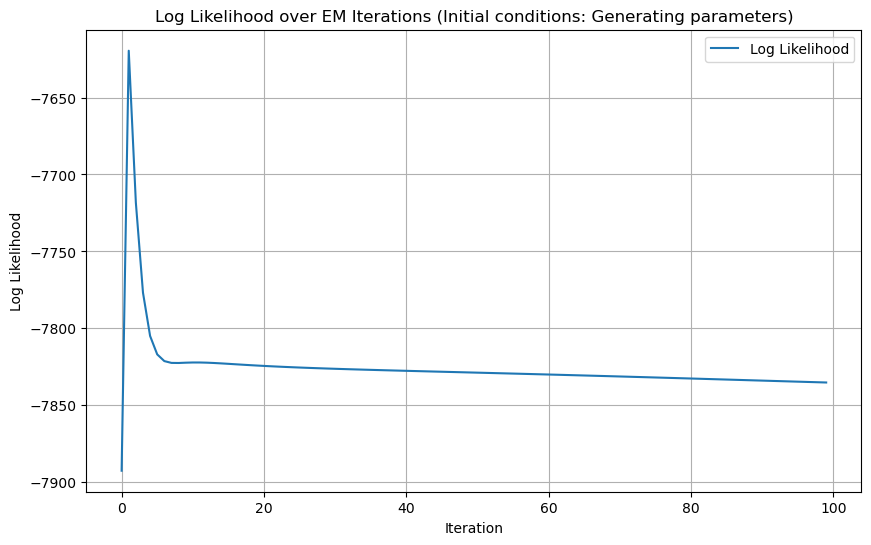

In [128]:
A_em, Q_em, C_em, R_em, log_likelihoods_para = em_algorithm(X, A, Q, C, R, y_init, Q_0)

# Plot log-likelihoods
plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods_para, label='Log Likelihood')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood over EM Iterations (Initial conditions: Generating parameters)')
plt.legend()
plt.grid()
plt.show()

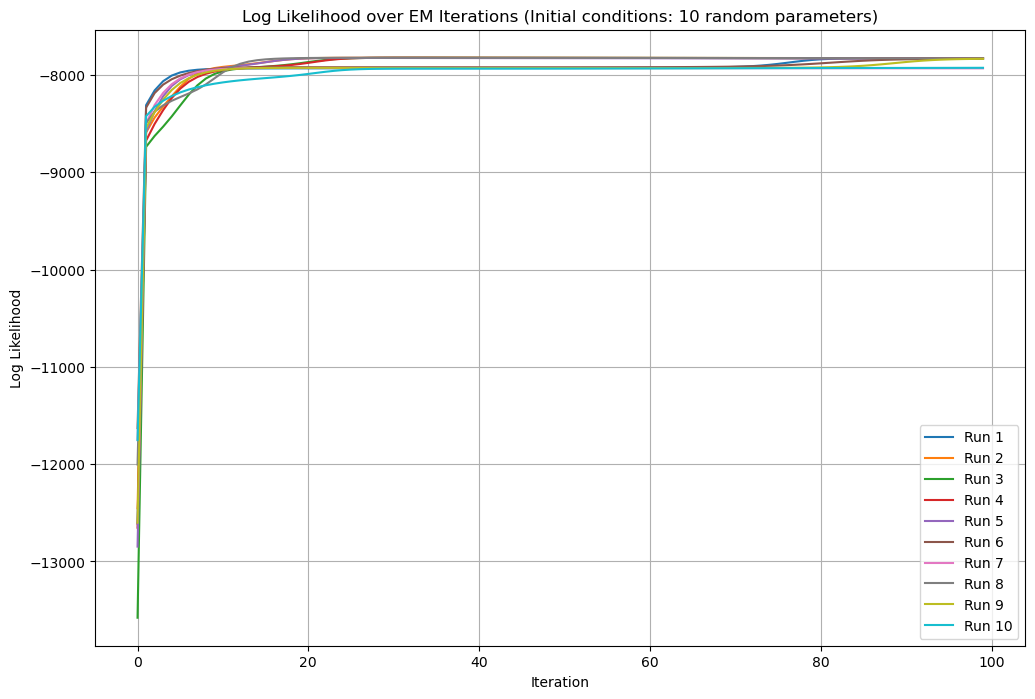

In [127]:
all_log_likelihoods = []

# Run EM with 10 random initializations
for i in range(10):
    A_rand = np.random.randn(*A.shape)  
    Q_rand = np.eye(A.shape[0])         
    C_rand = np.random.randn(*C.shape)  
    R_rand = np.eye(X.shape[0])         

    A_ra, Q_ra, C_ra, R_ra, log_likelihoods_rand = em_algorithm(X, A_rand, Q_rand, C_rand, R_rand, y_init, Q_0)
    
    all_log_likelihoods.append(log_likelihoods_rand)

plt.figure(figsize=(12, 8))

for i, log_likelihoods in enumerate(all_log_likelihoods):
    plt.plot(log_likelihoods, label=f'Run {i+1}') 

plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood over EM Iterations (Initial conditions: 10 random parameters)')
plt.legend()
plt.grid()
plt.show()


# Question 5 (a)

In [130]:
!pip install ace_tools

In [4]:
import requests
from collections import defaultdict, Counter
import pandas as pd

# Step 1: Download and preprocess text
url = 'https://www.gutenberg.org/files/2600/2600-0.txt'
response = requests.get(url)
text = response.text

# Preprocess the text: keep only letters, spaces, and punctuation
filtered_text = ''.join(c if c.isalnum() or c in " .,!?;:()[]" else ' ' for c in text.lower())

# Step 2: Count occurrences of symbols and symbol pairs
symbol_counts = Counter(filtered_text)
pair_counts = defaultdict(int)

# Count pairs of consecutive symbols
for i in range(len(filtered_text) - 1):
    pair = (filtered_text[i], filtered_text[i + 1])
    pair_counts[pair] += 1

# List of unique symbols (for matrix dimensions)
symbols = sorted(symbol_counts.keys())
symbol_indices = {symbol: idx for idx, symbol in enumerate(symbols)}

# Step 3: Calculate transition probabilities and store them in a matrix
matrix_size = len(symbols)
transition_matrix = [[0.0] * matrix_size for _ in range(matrix_size)]

for (prev_symbol, curr_symbol), count in pair_counts.items():
    if symbol_counts[prev_symbol] > 0:
        prob = count / symbol_counts[prev_symbol]
        transition_matrix[symbol_indices[prev_symbol]][symbol_indices[curr_symbol]] = prob

# Step 4: Generate LaTeX code for the transition matrix
latex_code = "\\begin{table}[h!]\n\\centering\n\\tiny\n\\begin{tabular}{" + "|c" * (matrix_size + 1) + "|}\n\\hline\n"
latex_code += " & " + " & ".join(symbols) + " \\\\\n\\hline\n"

for i, row in enumerate(transition_matrix):
    latex_code += symbols[i] + " & " + " & ".join(f"{value:.2e}" for value in row) + " \\\\\n\\hline\n"

latex_code += "\\end{tabular}\n\\caption{Transition Matrix $\\Psi$}\n\\end{table}"

# Print LaTeX code for the transition matrix
print(latex_code)


\begin{table}[h!]
\centering
\tiny
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
 &   & ! & ( & ) & , & . & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & : & ; & ? & [ & ] & a & b & c & d & e & f & g & h & i & j & k & l & m & n & o & p & q & r & s & t & u & v & w & x & y & z & à & á & â & ä & æ & ç & è & é & ê & ë & í & î & ï & ó & ô & ö & ú & ü & ý & œ \\
\hline
  & 1.50e-01 & 7.37e-06 & 9.80e-04 & 2.50e-05 & 2.50e-05 & 7.81e-05 & 2.95e-06 & 3.77e-04 & 3.98e-05 & 2.36e-05 & 1.47e-05 & 1.33e-05 & 2.95e-05 & 1.03e-05 & 1.62e-05 & 1.03e-05 & 0.00e+00 & 1.03e-05 & 3.39e-05 & 2.95e-06 & 0.00e+00 & 1.03e-01 & 3.73e-02 & 3.18e-02 & 2.57e-02 & 1.75e-02 & 3.17e-02 & 1.45e-02 & 7.36e-02 & 4.59e-02 & 2.45e-03 & 5.99e-03 & 2.02e-02 & 2.91e-02 & 2.24e-02 & 5.04e-02 & 2.80e-02 & 2.10e-03 & 2.26e-02 & 6.69e-02 & 1.31e-01 & 8.38e-03 & 6.08e-03 & 6.02e-02 & 6.61e-04 & 1.00e-02 & 2.33e-04 & 3.9

# Question 5 (d)

In [80]:
import requests
from collections import defaultdict, Counter
import pandas as pd
import random
import numpy as np
from collections import Counter, defaultdict

url = 'https://www.gutenberg.org/files/2600/2600-0.txt'
response = requests.get(url)
text = response.text

np.random.seed(42)
random.seed(42)

class Decrypter:
    def __init__(self, decryption_dict):
        self.decryption_dict = decryption_dict

    def decrypt(self, encrypted_message):
        return ''.join(self.decryption_dict.get(char, char) for char in encrypted_message)

def initialize_parameters_by_frequency(encrypted_text):
    """Initialize mapping based on English letter frequencies."""

    english_freq_order = " etaoinshrdlcumwfgypbvkjxqz0123456789.,!?"
    
    all_symbols = set(encrypted_text)
    
    mapping = {}
    
    available_targets = list(english_freq_order)
    for symbol in all_symbols:
        if len(available_targets) > 0:
            mapping[symbol] = available_targets.pop(0)
        else:
            mapping[symbol] = symbol
            
    return mapping

def calculate_transition_probs(text):
    """Calculate transition probabilities with smoothing."""
    transitions = defaultdict(lambda: defaultdict(lambda: 0.01))  
    char_counts = defaultdict(lambda: 0)
    
    for i in range(len(text)-1):
        curr, next_char = text[i], text[i+1]
        transitions[curr][next_char] += 1
        char_counts[curr] += 1
    
    for char in transitions:
        total = sum(transitions[char].values())
        for next_char in transitions[char]:
            transitions[char][next_char] /= total
    
    return transitions

def compute_log_likelihood(text, transitions):
    """Compute log likelihood of text using transition probabilities."""
    log_prob = 0
    for i in range(len(text)-1):
        curr, next_char = text[i], text[i+1]
        prob = transitions[curr][next_char]
        log_prob += np.log(max(prob, 1e-10))  
    return log_prob


def metropolis_hastings_decrypt(encrypted_text, transitions, n_iterations=10000, report_interval=100):
    """Run Metropolis-Hastings algorithm with simulated annealing."""
    current_mapping = initialize_parameters_by_frequency(encrypted_text)
    current_decrypter = Decrypter(current_mapping)
    
    current_decrypt = current_decrypter.decrypt(encrypted_text)
    current_score = compute_log_likelihood(current_decrypt, transitions)
    
    best_score = current_score
    best_mapping = current_mapping.copy()
    best_decrypt = current_decrypt
    
    decryption_log = [(0, current_decrypt[:60])]
    
    # Temperature schedule
    temp = 1.0
    cooling_rate = 0.9999
    
    # Get all unique symbols from encrypted text
    symbols = list(set(encrypted_text))  
    
    for i in range(n_iterations):
        new_mapping = current_mapping.copy()
        s1, s2 = random.sample(symbols, 2)
        new_mapping[s1], new_mapping[s2] = new_mapping[s2], new_mapping[s1]
        
        new_decrypter = Decrypter(new_mapping)
        new_decrypt = new_decrypter.decrypt(encrypted_text)
        new_score = compute_log_likelihood(new_decrypt, transitions)
        
        score_diff = new_score - current_score
        if score_diff > 0 or random.random() < np.exp(score_diff / temp):
            current_mapping = new_mapping
            current_score = new_score
            current_decrypt = new_decrypt
            
            if current_score > best_score:
                best_score = current_score
                best_mapping = current_mapping.copy()
                best_decrypt = current_decrypt
        
        if (i + 1) % report_interval == 0:
            decryption_log.append((i + 1, current_decrypt[:60]))
        
        # Cool temperature
        temp *= cooling_rate
    
    return best_mapping, best_decrypt, decryption_log

def run_decryption(encrypted_message, training_text):
    """Run the decryption process and display progress."""
    # Calculate transition probabilities from training text
    transitions = calculate_transition_probs(training_text)
    
    # Run Metropolis-Hastings
    _, decrypted_text, log = metropolis_hastings_decrypt(
        encrypted_message, 
        transitions,
        n_iterations=5000,
        report_interval=100
    )
    
    # Print progress
    print("\nMH Iteration | Current Decryption")
    print("-" * 80)
    for iteration, text in log:
        print(f"{iteration:>10} | {text}")
    
    return decrypted_text

# Run the decryption
file_path = '/Users/richardhuang/Documents/GitHub/Projects/Probabilistc Summartive/message.txt'  # Update with your file path
with open(file_path, 'r') as file:
    encrypted_message = file.read().strip()

decrypted_result = run_decryption(
    encrypted_message=encrypted_message,
    training_text=text  # From War and Peace download
)


MH Iteration | Current Decryption
--------------------------------------------------------------------------------
         0 | fwxm3x3hdwt1 x2wrxmh 1xydqw1 2eq1x312 gxm3x42ln1 xt2y1xm1xgh
       100 |  o2w4243joa102nor2w3012mjdo10ned1241n0g2w42qnli102anm12w12g3
       200 | e3 s4 4gj3r10 n32 sg01 mjd310nid1 41n0o s4 qnla10 rnm1 s1 og
       300 | e3 s4 4gh3r0y n32 sgy0 1hd30ynid0 40nyo s4 fnla0y rn10 s0 og
       400 | e0 s4 4ch0o3y n0d scy3 1h203yni23 43nyt s4 knla3y on13 s3 tc
       500 | e4 s1 1ch43of n4d scfo rhg4ofnigo 1onft s1 knlaof 3nro so tc
       600 | o4 s1 1ai4vef n4d safe rig4efnpge 1enft s1 kncuef vnre se ta
       700 | o3 ml lai3jes n3d mase vig3esnbge lenst ml kncues jnve me ta
       800 | o3 mg gai3res n3d mase vil3esnble genst mg knches rnve me ta
       900 | on mg gainres und mase vilnesuble geust mg kuches ruve me ta
      1000 | on py yaincer und pare vilnerufle yeurt py kusher cuve pe ta
      1100 | on my yaincer und mare vilneruble yeurt my kusher cuve me